# Logistic Regression 구현하기

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

## Data

In [3]:
np.random.seed(42)

train_X = np.random.randn(1000)
train_X[:500] = train_X[:500] + 4
train_y = np.array([1]*500 + [0]*500)

ids = np.arange(1000)
np.random.shuffle(ids)
train_X = train_X[ids]
train_y = train_y[ids]

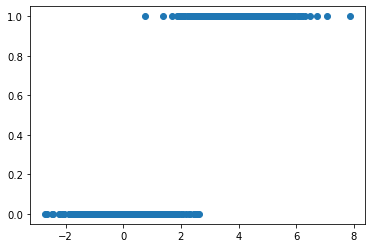

In [4]:
_ = plt.scatter(train_X, train_y)

## Implement

In [5]:
# reset 0 weights, bias
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print(f"Early w: {w}, b: {b}")

Early w: tensor([0.], requires_grad=True), b: tensor([0.], requires_grad=True)


In [6]:
# optimizer - 확률적 경사 하강법
optimizer = torch.optim.SGD([w, b], lr=0.2)

In [7]:
train_X, train_y = torch.FloatTensor(train_X), torch.FloatTensor(train_y)

In [8]:
# Approximation
e, l = [], []
for epoch in range(1001):
    # Loss - binary cross entropy
    appr = torch.sigmoid(w*train_X+b)
    loss = F.binary_cross_entropy(appr, train_y)
    # Updates Params
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Print and Collect Log
    e.append(epoch)
    l.append(loss.detach().numpy())
    if epoch%100==0:
        print(f"Epochs: {epoch:5d} - Loss: {loss:.5f}")

Epochs:     0 - Loss: 0.69315
Epochs:   100 - Loss: 0.15076
Epochs:   200 - Loss: 0.10955
Epochs:   300 - Loss: 0.09282
Epochs:   400 - Loss: 0.08355
Epochs:   500 - Loss: 0.07758
Epochs:   600 - Loss: 0.07339
Epochs:   700 - Loss: 0.07027
Epochs:   800 - Loss: 0.06786
Epochs:   900 - Loss: 0.06592
Epochs:  1000 - Loss: 0.06434


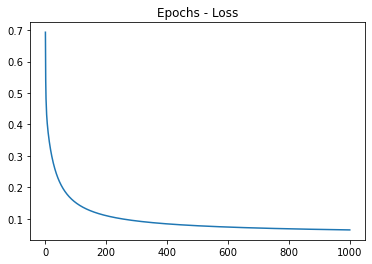

In [9]:
plt.plot(e, l)
plt.title("Epochs - Loss")
plt.show()

In [10]:
print(f"After Approximate w: {w}, b: {b}")

After Approximate w: tensor([2.6216], requires_grad=True), b: tensor([-5.1346], requires_grad=True)


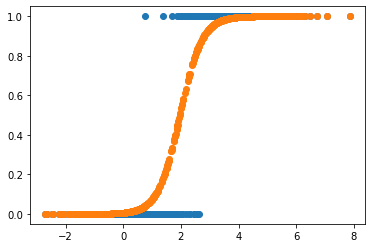

In [11]:
plt.scatter(train_X, train_y)
plt.scatter(train_X, appr.detach().numpy())
plt.show()

## 서포터님이 구현한 방식

In [12]:
# Reference: https://smwgood.tistory.com/6

from torch.autograd import Function

class Sigmoid(Function):

    @staticmethod
    def forward(ctx, logits):
        probs = 1 / (1 + torch.exp(-logits))
        ctx.save_for_backward(probs)
        return probs

    @staticmethod
    def backward(ctx, *grad_outputs):
        probs, = ctx.saved_tensors
        return probs * (1-probs)


class CrossEntropyWithLogits(Function):

    @staticmethod
    def forward(ctx, logits, targets):
        probs = 1 / (1 + torch.exp(-logits))
        ctx.save_for_backward(probs, targets)
        return -( targets*torch.log(probs) + (1-targets)*torch.log(1-probs) ).mean()

    @staticmethod
    def backward(ctx, *grad_outputs):
        probs, targets = ctx.saved_tensors
        grad_input = probs - targets
        return grad_input, None

In [13]:
logits  = torch.randn(10, requires_grad=True)
targets = (torch.rand(10) > 0.5).to(dtype=torch.long)
logits, targets

(tensor([-0.0578, -0.2759,  1.4966, -1.6991,  0.7557,  0.5992,  1.1118, -0.6826,
          0.1755, -0.0991], requires_grad=True),
 tensor([0, 0, 1, 0, 0, 1, 1, 1, 0, 1]))

In [14]:
sigmoid = Sigmoid.apply
cross_entropy_with_logits = CrossEntropyWithLogits.apply

In [15]:
probs = sigmoid(logits)
probs

tensor([0.4855, 0.4315, 0.8171, 0.1546, 0.6804, 0.6455, 0.7525, 0.3357, 0.5438,
        0.4752], grad_fn=<SigmoidBackward>)

In [16]:
loss = cross_entropy_with_logits(logits, targets)
loss

tensor(0.6082, grad_fn=<CrossEntropyWithLogitsBackward>)

In [18]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
lr = 0.001

for epoch in range(100):
    logits = a + b * train_X
    loss = cross_entropy_with_logits(logits, train_y)
    loss.backward()

    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad

        a.grad.zero_()
        b.grad.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} -- {loss.item():.6f}")

Epoch 0 -- 0.311211
Epoch 10 -- 0.178968
Epoch 20 -- 0.137678
Epoch 30 -- 0.117203
Epoch 40 -- 0.104800
Epoch 50 -- 0.096401
Epoch 60 -- 0.090298
Epoch 70 -- 0.085640
Epoch 80 -- 0.081956
Epoch 90 -- 0.078961


In [19]:
print(f"a: {a}, b: {b}")

a: tensor([-4.1591], requires_grad=True), b: tensor([2.2001], requires_grad=True)


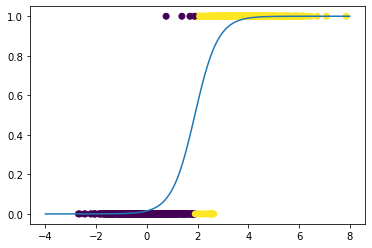

In [20]:
db_x = np.linspace(-4, 8, 121)
db_y = a.detach().numpy() + b.detach().numpy() * db_x
db_y = 1 / (1 + np.exp(-db_y))
plt.plot(db_x, db_y)

c = np.where(a + b * train_X > 0.0, 1, 0)
plt.scatter(train_X, train_y, c=c)
plt.show()